In [1]:
#All the imports
import time
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import multiprocessing
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from sklearn import utils
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import StackingClassifier
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\18643\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\18643\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\18643\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\18643\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [2]:
#Record run time for code to decide on size of data set to use for analysis
StartTime = time.time()

In [3]:
#Read in two very different data frames (Luxury Beauty and Video Games)
LuxuryBeautyDF = pd.read_json('Luxury_Beauty.json', lines=True)
VideoGamesDF = pd.read_json('Video_Games_5.json', lines=True)

In [4]:
#Create binary category columns for Luxury Beauty and Video Games
LuxuryBeautyDF['LuxBea'] = 1
LuxuryBeautyDF['VidGam'] = 0
VideoGamesDF['LuxBea'] = 0
VideoGamesDF['VidGam'] = 1

In [5]:
#Blend both dataframes into one, shuffle rows
#For computational time, limiting to approximately 100,000 reviews
Blend = [LuxuryBeautyDF,VideoGamesDF]
BlendDF = pd.concat(Blend)
BlendDF = BlendDF.sample(frac = 0.1).reset_index()

In [6]:
#Add column with Date from converted Unix time. Unfortunately results does not give time.
BlendDF["Date"] = pd.to_datetime(BlendDF["unixReviewTime"], unit='s')

In [7]:
#Create binary rating column: 0 (negative = 1-2), 1 (positive = 3-5)
#Binning decision came from running tests against validation data
conditions = [
    (BlendDF["overall"] > 2),
    (BlendDF["overall"] < 3)
    ]
values = [1, 0]
BlendDF['BinaryRating'] = np.select(conditions, values)

In [8]:
#Create column of review text with all lowercase, no punctuation, and no stopwords
nan_value = float("NaN") #Create na variable for blanks
BlendDF["reviewText"].replace("", nan_value, inplace=True) #Replace blanks with na variable
BlendDF.dropna(subset = ["reviewText"], inplace=True) #Drop all rows with na review text
BlendDF["ReviewNoFiller"] = BlendDF["reviewText"].str.replace('[^\w\s]','',regex=True) #Create column with review text with no punctuation
BlendDF["ReviewNoFiller"] = BlendDF["ReviewNoFiller"].str.lower() #Make all words lowercase
stopwords = stopwords.words('english') #Create stopwords variable
BlendDF["ReviewNoFiller"] = BlendDF["ReviewNoFiller"].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)])) #Remove stop words
BlendDF["ReviewNoFiller"].replace("", nan_value, inplace=True,regex=True) #Replace blanks with na
BlendDF.dropna(subset = ["ReviewNoFiller"], inplace=True) #Drop all rows with na review text, reset indices
BlendDF = BlendDF.sample(frac = 1).reset_index() #Randomize resulting dataframe and reset indices

In [9]:
#Insert columns with tokenized review and summary
BlendDF["ReviewToken"] = BlendDF.apply(lambda row: word_tokenize(row["ReviewNoFiller"]), axis=1)

In [10]:
#Lemmatize all reviews and summaries, rejoin the strings
WNL = WordNetLemmatizer()
def lemmatize_text(text):
    return [WNL.lemmatize(w) for w in text]
BlendDF['ReviewToken'] = BlendDF.ReviewToken.apply(lemmatize_text)
BlendDF['ReviewLemma'] = BlendDF['ReviewToken'].apply(' '.join)

In [11]:
#Print out distribution of resulting review ratings
print(BlendDF['overall'].value_counts())

5    68239
4    16343
3     9073
1     8084
2     5284
Name: overall, dtype: int64


In [12]:
#Insert column with VADER sentiment analysis compound score of full review text, scale numbers from 1 to 5
vader = SentimentIntensityAnalyzer()
BlendDF["VaderCompound"] = [vader.polarity_scores(x)['compound'] for x in BlendDF['reviewText']]
scaler = MinMaxScaler(feature_range=(1,5))
BlendDF["VaderCompound"] = scaler.fit_transform(BlendDF["VaderCompound"].values.reshape(-1,1))

In [13]:
#Insert column with review word count
BlendDF["WordCount"] = BlendDF["ReviewToken"].apply(len)

count    107023.000000
mean         40.604945
std          85.375955
min           1.000000
25%           6.000000
50%          15.000000
75%          37.000000
max        2741.000000
Name: WordCount, dtype: float64


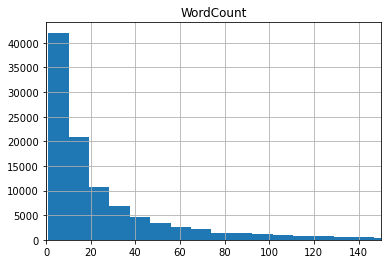

In [14]:
#What does word count distribution look like? Need visualization to decide how to bin data. Also look at descriptive statistics.
WordHist = BlendDF.hist(column = 'WordCount', bins=300)
plt.xlim([0,150])
print(BlendDF["WordCount"].describe()) #25% is 6 or less, 25% is 29 words or more, will bin accordingly

In [15]:
#Create column categorizing review word count as short (1) or not (0)
conditions = [
    (BlendDF["WordCount"] < 7),
    (BlendDF["WordCount"] > 6)
    ]
values = [1,0]
BlendDF['Short'] = np.select(conditions, values)

In [16]:
#Create column categorizing review word count as long (1) or not (0)
conditions = [
    (BlendDF["WordCount"] > 28),
    (BlendDF["WordCount"] < 29)
    ]
values = [1,0]
BlendDF['Long'] = np.select(conditions, values)

In [17]:
#Create column categorizing reviewer as verified (1) or not (0)
conditions = [
    (BlendDF['verified'] == True),
    (BlendDF['verified'] == False)
    ]
values = [1, 0]
BlendDF['Verified'] = np.select(conditions, values)

In [18]:
#Create binary column if the reviewer uploaded an image (1) or did not (0)
conditions = [
    (pd.notnull(BlendDF['image'])),
    (pd.isnull(BlendDF['image']))
    ]
values = [1, 0]
BlendDF['IsImage'] = np.select(conditions, values)

In [19]:
#Adjust vote column to allow for analysis
print(BlendDF.dtypes,'\n')
BlendDF['vote'] = BlendDF['vote'].str.replace('[^\w\s]','',regex=True) #Remove all punctuation from strings
BlendDF['vote'].replace('', '0', inplace=True) #Replace blanks with 0
BlendDF['vote'] = BlendDF['vote'].fillna('0') # Replace na values with 0
BlendDF['vote'] = BlendDF['vote'].astype({'vote': 'int32'})
print(BlendDF.dtypes,'\n')

level_0                    int64
index                      int64
overall                    int64
vote                      object
verified                    bool
reviewTime                object
reviewerID                object
asin                      object
reviewerName              object
reviewText                object
summary                   object
unixReviewTime             int64
style                     object
image                     object
LuxBea                     int64
VidGam                     int64
Date              datetime64[ns]
BinaryRating               int32
ReviewNoFiller            object
ReviewToken               object
ReviewLemma               object
VaderCompound            float64
WordCount                  int64
Short                      int32
Long                       int32
Verified                   int32
IsImage                    int32
dtype: object 

level_0                    int64
index                      int64
overall                    

In [20]:
#Read into five emotions lexicon, convert into five dictionaries
WarrinerWords = pd.read_csv("Warriner_BE.txt", sep='\t')
JoyDict = dict(zip(WarrinerWords.Word, WarrinerWords.Joy))
AngerDict = dict(zip(WarrinerWords.Word, WarrinerWords.Anger))
SadnessDict = dict(zip(WarrinerWords.Word, WarrinerWords.Sadness))
FearDict = dict(zip(WarrinerWords.Word, WarrinerWords.Fear))
DisgustDict = dict(zip(WarrinerWords.Word, WarrinerWords.Disgust))

In [21]:
#Create columns for five emotions, initialize all of them at zero
BlendDF['Joy'] = 0.0
BlendDF['Anger'] = 0.0
BlendDF['Sadness'] = 0.0
BlendDF['Fear'] = 0.0
BlendDF['Disgust'] = 0.0

In [22]:
#Iterate through all lists of words, assigning them scores for all emotions
for index, row in BlendDF.iterrows():
    for word in row['ReviewToken']:
        BlendDF.at[index,'Joy'] += JoyDict.get(word,0)
        BlendDF.at[index,'Anger'] += AngerDict.get(word,0)
        BlendDF.at[index,'Sadness'] += SadnessDict.get(word,0)
        BlendDF.at[index,'Fear'] += FearDict.get(word,0)
        BlendDF.at[index,'Disgust'] += DisgustDict.get(word,0)

In [23]:
#Create data frame for analysis
BlendDF = BlendDF[['ReviewLemma','VaderCompound','Short','Verified','Long','IsImage','WordCount','vote',
                   'LuxBea','VidGam','Joy','Anger','Sadness','Fear','Disgust','overall','BinaryRating']]

#Print some of the dataframe to verify work
pd.set_option('display.max_columns', None) #So as not to truncate output
pd.set_option('display.max_rows', None) #So as not to truncate output
for col in BlendDF.columns: #Print column names
    print(col)
print(BlendDF.head()) # Print first five entries in dataframe
print("The number of rows in the data frame is:", len(BlendDF.index))

ReviewLemma
VaderCompound
Short
Verified
Long
IsImage
WordCount
vote
LuxBea
VidGam
Joy
Anger
Sadness
Fear
Disgust
overall
BinaryRating
                                         ReviewLemma  VaderCompound  Short  \
0  hard find spray wax give nice shine hold well ...       4.918196      0   
1  great product little stubborn blackhead get to...       4.644382      0   
2  doesnt cover quite well hoped wouldsorry freck...       3.973149      0   
3                                               love       4.273964      1   
4  wonderful light scent jasmine known promote re...       4.663383      0   

   Verified  Long  IsImage  WordCount  vote  LuxBea  VidGam      Joy    Anger  \
0         1     0        0         23     0       1       0  48.2860  23.7234   
1         1     1        0         33     0       1       0  50.5892  25.1239   
2         1     0        0         12     0       1       0  11.6575   7.8056   
3         1     0        0          1     0       1       0   4.1631   1

In [24]:
# Write final dataframe into csv
BlendDF.to_csv(r'BlendedReviews.csv', index = False)

In [25]:
"""
TF-IDF Approach
First group of models are binary models predicting positive or negative rating
"""

#Implement TF-IDF for binary model
tfidf = TfidfVectorizer(max_features=100000, ngram_range=(1,7), analyzer='char')
X = tfidf.fit_transform(BlendDF['ReviewLemma'])
Y = BlendDF['BinaryRating']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1) #Split into 80/20 train and test sets

#Run binary logistic regression
LR = linear_model.LogisticRegression(solver='lbfgs',max_iter=10000)
LR.fit(X_train, Y_train)

#Look at ability of model to predict test set
LRScore = round((LR.score(X_test, Y_test))*100,2)
print('Binary Logistic Model Score for TF-IDF:',LRScore,'%','\n')
Y_pred = LR.predict(X_test)
print(classification_report(Y_test, Y_pred, zero_division=0), '\n')

#Implement Linear SVC model for binary TF-IDF
LSVC = LinearSVC(C = 10, class_weight='balanced', max_iter=10000)
LSVC.fit(X_train, Y_train)
LSVCScore = round((LSVC.score(X_test, Y_test))*100,2)
print('Binary Linear SVC Model Score for TFIDF is:',LSVCScore,'%', '\n')
Y_pred = LSVC.predict(X_test)
print(classification_report(Y_test, Y_pred, zero_division=0), '\n')

#Run K Nearest Neighbors Algorithm
KNN = KNeighborsClassifier(n_neighbors = 5)
KNN.fit(X_train, Y_train)

#Look at ability of model to predict test set
KNNScore = round((KNN.score(X_test, Y_test))*100,2)
print('K Nearest Neighbors Algorithm Model Score for TF-IDF: ',KNNScore,'%','\n')
Y_pred = KNN.predict(X_test)
print(classification_report(Y_test, Y_pred, zero_division=0), '\n')

Binary Logistic Model Score for TF-IDF: 91.45 % 

              precision    recall  f1-score   support

           0       0.81      0.40      0.54      2649
           1       0.92      0.99      0.95     18756

    accuracy                           0.91     21405
   macro avg       0.87      0.69      0.75     21405
weighted avg       0.91      0.91      0.90     21405
 

Binary Linear SVC Model Score for TFIDF is: 89.73 % 

              precision    recall  f1-score   support

           0       0.58      0.64      0.61      2649
           1       0.95      0.93      0.94     18756

    accuracy                           0.90     21405
   macro avg       0.76      0.79      0.77     21405
weighted avg       0.90      0.90      0.90     21405
 

K Nearest Neighbors Algorithm Model Score for TF-IDF:  88.35 % 

              precision    recall  f1-score   support

           0       0.60      0.18      0.27      2649
           1       0.89      0.98      0.94     18756

    accur

In [26]:
"""
TF-IDF Approach
Second group of models are multiclass models for 1-5 rating
"""
#Implement TF-IDF for multiclass model
tfidf = TfidfVectorizer(max_features=100000, ngram_range=(1,7), analyzer='char')
X = tfidf.fit_transform(BlendDF['ReviewLemma'])
Y = BlendDF['overall']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1) #Split into 80/20 train and test sets

#Run multinomial logistic regression
MLR = linear_model.LogisticRegression(multi_class='multinomial', solver='lbfgs',max_iter=10000)
MLR.fit(X_train, Y_train)

#Look at ability of model to predict test set
MLRScore = round((MLR.score(X_test, Y_test))*100,2)
print('Multinomial Logistic Model Score for TF-IDF: ',MLRScore,'%','\n')
Y_pred = MLR.predict(X_test)
print(classification_report(Y_test, Y_pred, zero_division=0), '\n')

#Implement Linear SVC model for TF-IDF multiclass
LSVC = LinearSVC(C = 10, class_weight='balanced', max_iter=10000)
LSVC.fit(X_train, Y_train)
LSVCScore = round((LSVC.score(X_test, Y_test))*100,2)
print('Multiclass Linear SVC Model Score for TFIDF is:',LSVCScore,'%', '\n')
Y_pred = LSVC.predict(X_test)
print(classification_report(Y_test, Y_pred, zero_division=0), '\n')

#Run K Nearest Neighbors Algorithm
KNN = KNeighborsClassifier(n_neighbors = 15)
KNN.fit(X_train, Y_train)

#Look at ability of model to predict test set
KNNScore = round((KNN.score(X_test, Y_test))*100,2)
print('K Nearest Neighbors Algorithm Model Score for TF-IDF: ',KNNScore,'%','\n')
Y_pred = KNN.predict(X_test)
print(classification_report(Y_test, Y_pred, zero_division=0), '\n')

Multinomial Logistic Model Score for TF-IDF:  70.81 % 

              precision    recall  f1-score   support

           1       0.63      0.56      0.59      1598
           2       0.30      0.04      0.07      1051
           3       0.42      0.21      0.28      1796
           4       0.44      0.22      0.30      3257
           5       0.76      0.96      0.85     13703

    accuracy                           0.71     21405
   macro avg       0.51      0.40      0.42     21405
weighted avg       0.65      0.71      0.66     21405
 

Multiclass Linear SVC Model Score for TFIDF is: 64.4 % 

              precision    recall  f1-score   support

           1       0.52      0.53      0.53      1598
           2       0.22      0.21      0.21      1051
           3       0.27      0.28      0.28      1796
           4       0.31      0.32      0.32      3257
           5       0.82      0.81      0.82     13703

    accuracy                           0.64     21405
   macro avg    

In [27]:
"""
Doc2Vec Approach
First group of models are binary models predicting positive or negative rating
"""

#Split into 80/20 train and test 
X = BlendDF['ReviewLemma']
Y = BlendDF['BinaryRating']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

#Function to label reviews train or test
def label_reviews(review, label_type):
    labeled = []
    for i,v in enumerate(review):
        label = label_type + '_' + str(i)
        labeled.append(TaggedDocument(v.split(), [label]))
    return labeled

#Label training and test sets using function
X_train = label_reviews(X_train, 'Train')
X_test = label_reviews(X_test,'Test')
AllData = X_train + X_test

#Build BOW Doc2Vec model
DBOWModel = Doc2Vec(dm=0, vector_size=300, negative=5, min_count=1, alpha=0.065, min_alpha=0.065)
DBOWModel.build_vocab([x for x in AllData])

#Iterate over data to train model
for epoch in range(30):
    DBOWModel.train(utils.shuffle([x for x in AllData]), total_examples=len(AllData), epochs=1)
    DBOWModel.alpha -= 0.002
    DBOWModel.min_alpha = DBOWModel.alpha

#Create function to vectorize all reviews
def get_vectors(model, corpus_size, vectors_size, vectors_type):
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = model.docvecs[prefix]
    return vectors

#Vectorize training and testing data
train_vectors_dbow = get_vectors(DBOWModel, len(X_train), 300, 'Train')
test_vectors_dbow = get_vectors(DBOWModel, len(X_test), 300, 'Test')

#Run binary logistic regression
LR = linear_model.LogisticRegression(solver='lbfgs',max_iter=10000)
LR = LR.fit(train_vectors_dbow, Y_train)

#Look at ability of model to predict test set
LRScore = round((LR.score(test_vectors_dbow, Y_test))*100,2)
print('Binary Logistic Model Score for Doc2Vec:',LRScore,'%','\n')
Y_pred = LR.predict(test_vectors_dbow)
print(classification_report(Y_test, Y_pred, zero_division=0), '\n')

#Run Binary SVM
svclassifier = SVC(kernel='linear')
svclassifier.fit(train_vectors_dbow, Y_train)

#Look at ability of model to predict test set
SVMScore = round((svclassifier.score(test_vectors_dbow, Y_test))*100,2)
print('Binary SVM Score for Doc2Vec is:',SVMScore,'%','\n')
Y_pred = svclassifier.predict(test_vectors_dbow)
print(classification_report(Y_test, Y_pred, zero_division=0), '\n')

#Run K Nearest Neighbors Algorithm
KNN = KNeighborsClassifier(n_neighbors = 5)
KNN.fit(train_vectors_dbow, Y_train)

#Look at ability of model to predict test set
KNNScore = round((KNN.score(test_vectors_dbow, Y_test))*100,2)
print('K Nearest Neighbors Algorithm Model Score for Doc2Vec: ',KNNScore,'%','\n')
Y_pred = KNN.predict(test_vectors_dbow)
print(classification_report(Y_test, Y_pred, zero_division=0), '\n')

C:\Users\18643\AppData\Local\Temp/ipykernel_10688/2799700782.py:39: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  vectors[i] = model.docvecs[prefix]


Binary Logistic Model Score for Doc2Vec: 90.61 % 

              precision    recall  f1-score   support

           0       0.70      0.42      0.52      2649
           1       0.92      0.98      0.95     18756

    accuracy                           0.91     21405
   macro avg       0.81      0.70      0.74     21405
weighted avg       0.90      0.91      0.90     21405
 

Binary SVM Score for Doc2Vec is: 90.71 % 

              precision    recall  f1-score   support

           0       0.75      0.38      0.50      2649
           1       0.92      0.98      0.95     18756

    accuracy                           0.91     21405
   macro avg       0.83      0.68      0.72     21405
weighted avg       0.90      0.91      0.89     21405
 

K Nearest Neighbors Algorithm Model Score for Doc2Vec:  89.26 % 

              precision    recall  f1-score   support

           0       0.64      0.31      0.41      2649
           1       0.91      0.98      0.94     18756

    accuracy      

In [28]:
"""
Doc2Vec Approach
Second group of models are multiclass models for 1-5 rating
"""

#Split into 80/20 train and test 
X = BlendDF['ReviewLemma']
Y = BlendDF['overall']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

#Label training and test sets using function
X_train = label_reviews(X_train, 'Train')
X_test = label_reviews(X_test,'Test')
AllData = X_train + X_test

#Build Doc2Vec model
DBOWModel = Doc2Vec(dm=0, vector_size=300, negative=5, min_count=1, alpha=0.065, min_alpha=0.065)
DBOWModel.build_vocab([x for x in AllData])

#Iterate over data to train model
for epoch in range(30):
    DBOWModel.train(utils.shuffle([x for x in AllData]), total_examples=len(AllData), epochs=1)
    DBOWModel.alpha -= 0.002
    DBOWModel.min_alpha = DBOWModel.alpha

#Vectorize training and testing data
train_vectors_dbow = get_vectors(DBOWModel, len(X_train), 300, 'Train')
test_vectors_dbow = get_vectors(DBOWModel, len(X_test), 300, 'Test')

#Run multinomial logistic regression
MLR = linear_model.LogisticRegression(multi_class='multinomial', solver='lbfgs',max_iter=10000)
MLR.fit(train_vectors_dbow, Y_train)

#Look at ability of model to predict test set
MLRScore = round((MLR.score(test_vectors_dbow, Y_test))*100,2)
print('Multinomial Logistic Model Score for Doc2Vec: ',MLRScore,'%','\n')
Y_pred = MLR.predict(test_vectors_dbow)
print(classification_report(Y_test, Y_pred, zero_division=0), '\n')

#Run Multiclass SVM
msvclassifier = SVC(kernel='linear')
msvclassifier.fit(train_vectors_dbow, Y_train)

#Look at ability of model to predict test set
MSVMScore = round((msvclassifier.score(test_vectors_dbow, Y_test))*100,2)
print('Multiclass SVM Score is for Doc2Vec: ',MSVMScore,'%','\n')
Y_pred = msvclassifier.predict(test_vectors_dbow)
print(classification_report(Y_test, Y_pred, zero_division=0), '\n')

#Run K Nearest Neighbors Algorithm
KNN = KNeighborsClassifier(n_neighbors = 15)
KNN.fit(train_vectors_dbow, Y_train)

#Look at ability of model to predict test set
KNNScore = round((KNN.score(test_vectors_dbow, Y_test))*100,2)
print('K Nearest Neighbors Algorithm Model Score for Doc2Vec: ',KNNScore,'%','\n')
Y_pred = KNN.predict(test_vectors_dbow)
print(classification_report(Y_test, Y_pred, zero_division=0), '\n')

C:\Users\18643\AppData\Local\Temp/ipykernel_10688/2799700782.py:39: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  vectors[i] = model.docvecs[prefix]


Multinomial Logistic Model Score for Doc2Vec:  69.17 % 

              precision    recall  f1-score   support

           1       0.56      0.53      0.55      1598
           2       0.27      0.06      0.10      1051
           3       0.35      0.20      0.26      1796
           4       0.44      0.19      0.26      3257
           5       0.75      0.94      0.83     13703

    accuracy                           0.69     21405
   macro avg       0.47      0.38      0.40     21405
weighted avg       0.63      0.69      0.64     21405
 

Multiclass SVM Score is for Doc2Vec:  68.61 % 

              precision    recall  f1-score   support

           1       0.57      0.55      0.56      1598
           2       0.33      0.06      0.11      1051
           3       0.34      0.20      0.25      1796
           4       0.18      0.00      0.00      3257
           5       0.72      0.98      0.83     13703

    accuracy                           0.69     21405
   macro avg       0.43 

In [29]:
"""
VADER Score
First group of models are binary models predicting positive or negative rating
"""

#Split data into training and test sets with a 80/20 split for all binary models
X = BlendDF[['VaderCompound','Short','Verified','Long','IsImage']] #set independent variables for regression
Y = BlendDF['BinaryRating'] #set dependent variable for regression
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1) #Split into 80/20 train and test sets

#Run binary logistic regression
LR = linear_model.LogisticRegression(solver='lbfgs',max_iter=10000)
LR.fit(X_train, Y_train)
print('Binary Logistic Intercept is:', LR.intercept_, '\n')
print('Binary Logistic Coefficients are:', LR.coef_, '\n')

#Look at ability of model to predict test set
LRScore = round((LR.score(X_test, Y_test))*100,2)
print('Binary Logistic Model Score for VADER Score:',LRScore,'%','\n')
Y_pred = LR.predict(X_test)
print(classification_report(Y_test, Y_pred, zero_division=0), '\n')

#Run Binary SVM
svclassifier = SVC(kernel='linear')
svclassifier.fit(X_train, Y_train)

#Look at ability of model to predict test set
SVMScore = round((svclassifier.score(X_test, Y_test))*100,2)
print('Binary SVM Score for VADER Score:',SVMScore,'%','\n')
Y_pred = svclassifier.predict(X_test)
print(classification_report(Y_test, Y_pred, zero_division=0), '\n')

#Run Naive Bayes Classifier
NB = GaussianNB()
NB.fit(X_train, Y_train)

#Look at ability of model to predict test set
NBScore = round((NB.score(X_test, Y_test))*100,2)
print('Binary Naive Bayes Classifier Score for VADER Score:',NBScore,'%','\n')
Y_pred = NB.predict(X_test)
print(classification_report(Y_test, Y_pred, zero_division=0), '\n')

#Implement stacked ensemble model
Estimators = [('NB',NB), ('SVM',svclassifier)]
StackedModel = StackingClassifier (estimators = Estimators, final_estimator = linear_model.LogisticRegression(solver='lbfgs',max_iter=10000))
StackedModel.fit(X_train, Y_train)

#Look at ability of stacked ensemble model to predict test set
StackScore = round((StackedModel.score(X_test, Y_test))*100,2)
print('Stacked ensemble model score for VADER Score: ',StackScore,'%','\n')
Y_pred = StackedModel.predict(X_test)
print(classification_report(Y_test, Y_pred, zero_division=0), '\n')

Binary Logistic Intercept is: [-2.21533408] 

Binary Logistic Coefficients are: [[ 1.04029738  0.6752489   0.23403658 -0.12925209 -0.86410831]] 

Binary Logistic Model Score for VADER Score: 88.03 % 

              precision    recall  f1-score   support

           0       0.54      0.24      0.33      2649
           1       0.90      0.97      0.93     18756

    accuracy                           0.88     21405
   macro avg       0.72      0.61      0.63     21405
weighted avg       0.86      0.88      0.86     21405
 

Binary SVM Score for VADER Score: 87.62 % 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2649
           1       0.88      1.00      0.93     18756

    accuracy                           0.88     21405
   macro avg       0.44      0.50      0.47     21405
weighted avg       0.77      0.88      0.82     21405
 

Binary Naive Bayes Classifier Score for VADER Score: 87.37 % 

              precision    recall 

In [30]:
"""
VADER Score
Second group of models are multiclass models for 1-5 rating
"""
#Split data into training and test sets with a 80/20 split for multiclass models
X = BlendDF[['VaderCompound','Short','Verified','Long','IsImage']] #set independent variables for regression
Y = BlendDF['overall'] #set dependent variable for regression
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1) #Split into 80/20 train and test sets

#Run multinomial logistic regression
MLR = linear_model.LogisticRegression(multi_class='multinomial', solver='lbfgs',max_iter=10000)
MLR.fit(X_train, Y_train)

#Look at ability of model to predict test set
MLRScore = round((MLR.score(X_test, Y_test))*100,2)
print('Multinomial Logistic Model Score for VADER Score: ',MLRScore,'%','\n')
Y_pred = MLR.predict(X_test)
print(classification_report(Y_test, Y_pred, zero_division=0), '\n')

#Run Multiclass SVM
msvclassifier = SVC(kernel='linear')
msvclassifier.fit(X_train, Y_train)

#Look at ability of model to predict test set
MSVMScore = round((msvclassifier.score(X_test, Y_test))*100,2)
print('Multiclass SVM Score is for VADER Score: ',MSVMScore,'%','\n')
Y_pred = msvclassifier.predict(X_test)
print(classification_report(Y_test, Y_pred, zero_division=0), '\n')

#Run K Nearest Neighbors Algorithm
KNN = KNeighborsClassifier(n_neighbors = 15)
KNN.fit(X_train, Y_train)

#Look at ability of model to predict test set
KNNScore = round((KNN.score(X_test, Y_test))*100,2)
print('K Nearest Neighbors Algorithm Model Score for VADER Score: ',KNNScore,'%','\n')
Y_pred = KNN.predict(X_test)
print(classification_report(Y_test, Y_pred, zero_division=0), '\n')

#Run Random Forest Algorithm
RF = RandomForestClassifier(n_estimators=5, random_state=0)
RF.fit(X_train, Y_train)

#Look at ability of model to predict test set
RFScore = round((RF.score(X_test, Y_test))*100,2)
print('Random Forest Classifier Model Score for VADER Score: ',RFScore,'%','\n')
Y_pred = RF.predict(X_test)
print(classification_report(Y_test, Y_pred, zero_division=0), '\n')

#Implement stacked ensemble model
Estimators = [('KNN',KNN), ('SVM',msvclassifier)]
StackedModel = StackingClassifier (estimators = Estimators, final_estimator = linear_model.LogisticRegression(multi_class='multinomial', solver='lbfgs',max_iter=10000))
StackedModel.fit(X_train, Y_train)

#Look at ability of stacked ensemble model to predict test set
StackScore = round((StackedModel.score(X_test, Y_test))*100,2)
print('Stacked ensemble model score for VADER Score: ',StackScore,'%','\n')
Y_pred = StackedModel.predict(X_test)
print(classification_report(Y_test, Y_pred, zero_division=0), '\n')

Multinomial Logistic Model Score for VADER Score:  65.22 % 

              precision    recall  f1-score   support

           1       0.36      0.39      0.37      1598
           2       0.00      0.00      0.00      1051
           3       0.14      0.01      0.01      1796
           4       0.19      0.00      0.00      3257
           5       0.68      0.97      0.80     13703

    accuracy                           0.65     21405
   macro avg       0.28      0.27      0.24     21405
weighted avg       0.50      0.65      0.54     21405
 

Multiclass SVM Score is for VADER Score:  65.21 % 

              precision    recall  f1-score   support

           1       0.36      0.35      0.36      1598
           2       0.00      0.00      0.00      1051
           3       0.00      0.00      0.00      1796
           4       0.00      0.00      0.00      3257
           5       0.68      0.98      0.80     13703

    accuracy                           0.65     21405
   macro avg    

In [31]:
"""
Five Emotions Approach and other variables approach
First group of models are binary models predicting positive or negative rating
SVM Models have been excluded due to high number of continuous variables makes processing power/time overwhelming
"""

#Split data into training and test sets with a 80/20 split for all binary models
#Based on the very low coefficients for both WordCount and vote, these variables were left out of the models.
X = BlendDF[['Joy','Anger','Sadness','Fear','Disgust','Short','Verified','Long','IsImage']] #set independent variables for regression
Y = BlendDF['BinaryRating'] #set dependent variable for regression
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1) #Split into 80/20 train and test sets

#Run Naive Bayes Classifier
NB = GaussianNB()
NB.fit(X_train, Y_train)

#Look at ability of model to predict test set
NBScore = round((NB.score(X_test, Y_test))*100,2)
print('Naive Bayes Classifier Score is for Five Emotions Model: ',NBScore,'%','\n')
Y_pred = NB.predict(X_test)
print(classification_report(Y_test, Y_pred, zero_division=0), '\n')

#Run binary logistic regression
LR = linear_model.LogisticRegression(solver='lbfgs',max_iter=10000)
LR.fit(X_train, Y_train)

#Look at ability of model to predict test set
LRScore = round((LR.score(X_test, Y_test))*100,2)
print('Binary Logistic Model Score for Five Emotions Model: ',LRScore,'%','\n')
Y_pred = LR.predict(X_test)
print(classification_report(Y_test, Y_pred, zero_division=0), '\n')

Naive Bayes Classifier Score is for Five Emotions Model:  87.01 % 

              precision    recall  f1-score   support

           0       0.22      0.02      0.04      2649
           1       0.88      0.99      0.93     18756

    accuracy                           0.87     21405
   macro avg       0.55      0.51      0.48     21405
weighted avg       0.80      0.87      0.82     21405
 

Binary Logistic Model Score for Five Emotions Model:  87.47 % 

              precision    recall  f1-score   support

           0       0.43      0.04      0.07      2649
           1       0.88      0.99      0.93     18756

    accuracy                           0.87     21405
   macro avg       0.65      0.51      0.50     21405
weighted avg       0.82      0.87      0.83     21405
 



In [32]:
"""
Five Emotions Approach and other variables approach
Second group of models are multiclass models for 1-5 rating
SVM Models have been excluded due to high number of continuous variables makes processing power/time overwhelming
"""

#Split data into training and test sets with a 80/20 split for multiclass models
#Based on the very low coefficients for both WordCount, vote and categories, these variables were left out of the models.
X = BlendDF[['Joy','Anger','Sadness','Fear','Disgust','Short','Verified','Long','IsImage']] #set independent variables for regression
Y = BlendDF['overall'] #set dependent variable for regression
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1) #Split into 80/20 train and test sets

#Run multinomial logistic regression
MLR = linear_model.LogisticRegression(multi_class='multinomial', solver='lbfgs',max_iter=10000)
MLR.fit(X_train, Y_train)

#Look at ability of model to predict test set
MLRScore = round((MLR.score(X_test, Y_test))*100,2)
print('Multinomial Logistic Model Score for Five Emotions Model: ',MLRScore,'%','\n')
Y_pred = MLR.predict(X_test)
print(classification_report(Y_test, Y_pred, zero_division=0), '\n')

#Run K Nearest Neighbors Algorithm
KNN = KNeighborsClassifier(n_neighbors = 15)
KNN.fit(X_train, Y_train)

#Look at ability of model to predict test set
KNNScore = round((KNN.score(X_test, Y_test))*100,2)
print('K Nearest Neighbors Algorithm Model Score for Five Emotions Model: ',KNNScore,'%','\n')
Y_pred = KNN.predict(X_test)
print(classification_report(Y_test, Y_pred, zero_division=0), '\n')

#Run Random Forest Algorithm
RF = RandomForestClassifier(n_estimators=5, random_state=0)
RF.fit(X_train, Y_train)

#Look at ability of model to predict test set
RFScore = round((RF.score(X_test, Y_test))*100,2)
print('Random Forest Classifier Model Score for Five Emotions Model: ',RFScore,'%','\n')
Y_pred = RF.predict(X_test)
print(classification_report(Y_test, Y_pred, zero_division=0), '\n')

Multinomial Logistic Model Score for Five Emotions Model:  63.99 % 

              precision    recall  f1-score   support

           1       0.28      0.06      0.10      1598
           2       0.13      0.00      0.01      1051
           3       0.17      0.01      0.01      1796
           4       0.35      0.02      0.04      3257
           5       0.65      0.99      0.78     13703

    accuracy                           0.64     21405
   macro avg       0.32      0.22      0.19     21405
weighted avg       0.51      0.64      0.52     21405
 

K Nearest Neighbors Algorithm Model Score for Five Emotions Model:  62.42 % 

              precision    recall  f1-score   support

           1       0.31      0.14      0.19      1598
           2       0.13      0.01      0.02      1051
           3       0.16      0.03      0.05      1796
           4       0.23      0.07      0.11      3257
           5       0.67      0.94      0.78     13703

    accuracy                        

In [33]:
"""
Print out run times to decide how big of a data set to use
"""

ElapsedSeconds = time.time() - StartTime
def convert(seconds):
    seconds = seconds % (24 * 3600)
    hour = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60

    return "%d:%02d:%02d" % (hour, minutes, seconds)
print(convert(ElapsedSeconds))

3:54:01
